In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

import os
import kaleido

In [166]:
ODAQ_results = pd.read_csv('./ODAQ/ODAQ_listening_test/ODAQ_results.csv')
ODAQ_results_BSU1 = pd.read_csv('./ODAQ_v1_BSU/Cohort_B1_results.csv')
ODAQ_results_BSU2 = pd.read_csv('./ODAQ_v1_BSU/Cohort_B2_results.csv')

In [167]:
methods = ODAQ_results['method'].unique()
conditions = ODAQ_results['condition'].unique()
processes = ODAQ_results['process'].unique()
items = ODAQ_results['item'].unique()

print(methods)
print(conditions)
print(processes)
print(items)

['LP' 'TM' 'UN' 'SH' 'PE' 'DE']
['LP3.5' 'LP7' 'Q1' 'Q2' 'Q3' 'Q4' 'Q5' 'Ref']
['LP35' 'LP70' 'LP50' 'LP90' 'LP105' 'LP120' 'LP150' 'reference' 'TM3k'
 'TM5k' 'TM7k' 'TM9k' 'TM10.5k' 'UN3k' 'UN5k' 'UN7k' 'UN9k' 'UN10.5k'
 'SH70_MS' 'SH50_MS' 'SH30_MS' 'SH20_MS' 'SH10_MS' 'PE_4096_MS_NMR10'
 'PE_2048_MS_NMR10' 'PE_1024_MS_NMR10' 'PE_2048_MS_NMR16'
 'PE_1024_MS_NMR16' 'OpenUnmix_mid' 'TFC_TDF_U_Net_mid' 'Cocktail_mid'
 'DeepFilterNet2_mid' 'PSM_quantize_mask']
['LP_11_guitar' 'LP_23_jazz' 'LP_AmateurOnPurpose'
 'LP_CreatureFromTheBlackjackTable' 'TM_01b_trumpet' 'TM_02_violin'
 'TM_AmateurOnPurpose' 'TM_CreatureFromTheBlackjackTable'
 'UN_20c_accordion' 'UN_21_violin' 'UN_AmateurOnPurpose'
 'UN_CreatureFromTheBlackjackTable' 'SH_04_choral' 'SH_13_glockenspiel'
 'SH_AmateurOnPurpose' 'SH_CreatureFromTheBlackjackTable'
 'PE_27_castanets' 'PE_39_clapping' 'PE_AmateurOnPurpose'
 'PE_CreatureFromTheBlackjackTable' 'DE_CosmosLandromat_remix1_LD6'
 'DE_CosmosLandromat_remix3_LD3' 'DE_ElephantsD

In [168]:
# Dynamically create expert variables
unique_subjects = ODAQ_results['subject'].unique()
for i, subject in enumerate(unique_subjects, start=1):
    globals()[f"expert{i}"] = ODAQ_results[ODAQ_results['subject'] == subject]

# Dynamically create BSU1 variables
unique_subjects_BSU1 = ODAQ_results_BSU1['subject'].unique()
for i, subject in enumerate(unique_subjects_BSU1, start=1):
    globals()[f"BSU1_{i}"] = ODAQ_results_BSU1[ODAQ_results_BSU1['subject'] == subject]

# Dynamically create BSU2 variables
unique_subjects_BSU2 = ODAQ_results_BSU2['subject'].unique()
for i, subject in enumerate(unique_subjects_BSU2, start=1):
    globals()[f"BSU2_{i}"] = ODAQ_results_BSU2[ODAQ_results_BSU2['subject'] == subject]
    
print('Experts: ', unique_subjects)
print('BSU1: ', unique_subjects_BSU1)
print('BSU2: ', unique_subjects_BSU2)

Experts:  ['Subject 1: USLA08' 'Subject 2: DEID44' 'Subject 3: DEID1115'
 'Subject 4: DEID337' 'Subject 5: USLA06' 'Subject 6: DEID5'
 'Subject 7: DEID9' 'Subject 8: DEID4' 'Subject 9: USLG04'
 'Subject 10: USLA04' 'Subject 11: USLA07' 'Subject 12: DEID256'
 'Subject 13: DEID6' 'Subject 14: USLG05' 'Subject 15: USLA09'
 'Subject 16: USLG02' 'Subject 17: USLG03' 'Subject 18: DEID7'
 'Subject 19: USLA12' 'Subject 20: DEID10' 'Subject 21: DEID8'
 'Subject 22: DEID2' 'Subject 23: USLA01' 'Subject 24: USLA05'
 'Subject 25: DEID1' 'Subject 26: DEID3']
BSU1:  ['D001' 'D002' 'D003' 'D004' 'D008' 'D009' 'D010' 'D011']
BSU2:  ['D005' 'D013' 'D014' 'D015' 'D016' 'D017' 'D018' 'D019']


In [169]:
# Initialize score lists dynamically for 26 experts
for i in range(1, 27):  # Assuming 26 experts
    globals()[f"expert{i}_scores"] = []

# Initialize score lists dynamically for BSU1
for i in range(1, 9):  # Assuming 26 experts
    globals()[f"BSU1_{i}_scores"] = []

# Initialize score lists dynamically for BSU2
for i in range(1, 9):  # Assuming 26 experts
    globals()[f"BSU2_{i}_scores"] = []

# Append scores systematically
for item in items:
    for i in range(1, 27):
        expert_df = globals()[f"expert{i}"]  # Access expert data frame
        scores = expert_df[expert_df['item'] == item]['score'].values
        globals()[f"expert{i}_scores"].append(scores)

    for i in range(1, 9):
        BSU1_df = globals()[f"BSU1_{i}"]
        scores = BSU1_df[BSU1_df['item'] == item]['score'].values
        globals()[f"BSU1_{i}_scores"].append(scores)

    for i in range(1, 9):
        BSU2_df = globals()[f"BSU2_{i}"]
        scores = BSU2_df[BSU2_df['item'] == item]['score'].values
        globals()[f"BSU2_{i}_scores"].append(scores)
        

In [170]:
# Function to compute rankings with penalty for ties
def competition_ranking(scores):
    """Returns competition-style rankings (ascending order), where ties get the same rank, and the next rank is skipped accordingly."""
    
    sorted_indices = np.argsort(scores)  # Sort in ascending order
    ranks = np.zeros_like(scores, dtype=int)
    
    rank = 1  # Start ranking from 1
    for i in range(len(scores)):
        if i > 0 and scores[sorted_indices[i]] == scores[sorted_indices[i - 1]]:
            ranks[sorted_indices[i]] = ranks[sorted_indices[i - 1]]  # Assign the same rank for ties
        else:
            ranks[sorted_indices[i]] = rank  # Assign new rank
        
        rank += 1  # Increment rank, ensuring skipped positions for ties
    
    return ranks


In [171]:
# Compute rankings systematically for 26 experts
for i in range(1, 27):  # Assuming 26 experts
    expert_scores = globals()[f"expert{i}_scores"]  # Get the score list
    globals()[f"expert{i}_rankings"] = np.array([competition_ranking(row) for row in expert_scores])

# Compute rankings systematically for BSU1
for i in range(1, 9):  # Assuming 8 BSU1 students
    BSU1_scores = globals()[f"BSU1_{i}_scores"]  # Get the score list
    globals()[f"BSU1_{i}_rankings"] = np.array([competition_ranking(row) for row in BSU1_scores])

# Compute rankings systematically for BSU2
for i in range(1, 9):  # Assuming 8 BSU2 students
    BSU2_scores = globals()[f"BSU2_{i}_scores"]  # Get the score list
    globals()[f"BSU2_{i}_rankings"] = np.array([competition_ranking(row) for row in BSU2_scores])

In [172]:
BSU1_5_scores

[array([ 10.,  36.,  20.,  37.,  51.,  79.,  94., 100.]),
 array([ 10.,  30.,  20.,  46.,  60.,  75.,  93., 100.]),
 array([ 10.,  31.,  20.,  51.,  59.,  79., 100.,  92.]),
 array([ 10.,  30.,  20.,  58.,  44.,  77.,  92., 100.]),
 array([ 10.,  20.,  41.,  58.,  67.,  81., 100.,  95.]),
 array([ 10.,  20.,  30.,  45.,  72.,  94.,  82., 100.]),
 array([ 10.,  20.,  46.,  33.,  60.,  80.,  90., 100.]),
 array([ 10.,  20.,  31.,  42.,  57.,  72.,  85., 100.]),
 array([ 10.,  20.,  33.,  42.,  66.,  80.,  90., 100.]),
 array([ 10.,  20.,  33.,  55.,  75.,  90.,  85., 100.]),
 array([ 11.,  19.,  38.,  61.,  55.,  86.,  75., 100.]),
 array([ 10.,  20.,  30.,  81.,  68.,  60., 100.,  93.]),
 array([ 10.,  23.,  44.,  56.,  60.,  75.,  85., 100.]),
 array([ 10.,  20.,  30.,  41.,  56.,  70.,  80., 100.]),
 array([ 10.,  20.,  26.,  38.,  62.,  80.,  48., 100.]),
 array([ 10.,  24.,  39.,  57.,  66.,  79.,  87., 100.]),
 array([ 10.,  20.,  40.,  46.,  70.,  58.,  83., 100.]),
 array([ 10., 

In [173]:
expert16_scores

[array([ 23.,  81.,  50.,  99.,  99., 100.,  99.,  99.]),
 array([ 26.,  90.,  55.,  96.,  99.,  99.,  99., 100.]),
 array([ 20.,  54.,  32.,  66.,  99.,  99., 100.,  99.]),
 array([ 16.,  54.,  33.,  95.,  98.,  99.,  99., 100.]),
 array([ 43.,  70.,  23.,  60.,  81.,  99., 100.,  99.]),
 array([ 41.,  72.,  44.,  51.,  97., 100.,  99.,  99.]),
 array([ 29.,  70.,  10.,  10.,  95.,  99., 100.,  99.]),
 array([ 23.,  62.,  20.,  18.,  76.,  99., 100.,  98.]),
 array([ 50.,  71.,  12.,  33.,  38.,  99.,  99., 100.]),
 array([ 31.,  69.,   6.,   8.,  20.,  96.,  92., 100.]),
 array([ 20.,  47.,  52.,  92.,  82.,  93., 100.,  99.]),
 array([ 31.,  70.,  58.,  99.,  99., 100.,  99.,  99.]),
 array([ 26.,  58.,  20.,  40.,  45.,  55.,  57., 100.]),
 array([ 24.,  86.,  14.,  50.,  49.,  56.,  76., 100.]),
 array([ 34.,  42.,  10.,  17.,  49.,  37.,  50., 100.]),
 array([ 23.,  65.,  16.,  26.,  33.,  31.,  77., 100.]),
 array([ 21.,  60.,  16.,  40.,  55.,  51.,  60., 100.]),
 array([ 27., 

In [174]:
cluster_colors = {
    '0': 'red',
    '1': 'blue',
    '2': 'green',
    '3': 'purple',
}

In [175]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import pandas as pd


def cluster_rows(matrix, n_clusters=3, random_state=42):
    """
    Performs row-wise clustering on a 2D matrix and returns a DataFrame
    with cluster labels ordered by cluster mean and original scores.

    Parameters:
    - matrix (np.ndarray): A 2D numpy array (e.g., 30x8).
    - n_clusters (int): Number of clusters for KMeans (default is 3).
    - random_state (int): Random seed for reproducibility.

    Returns:
    - pd.DataFrame: DataFrame with 9 columns: 'cluster', 'Q1' to 'Q8'.
    """
    # Standardize the data for clustering
    scaler = StandardScaler()
    matrix_scaled = scaler.fit_transform(matrix)

    # KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    clusters = kmeans.fit_predict(matrix_scaled)

    # Assign original cluster labels
    df = pd.DataFrame(matrix, columns=[f"Q{i+1}" for i in range(matrix.shape[1])])
    df['cluster'] = clusters

    # Compute mean of rows within each cluster
    cluster_means = df.groupby('cluster').mean().mean(axis=1)

    # Sort cluster labels by mean and create a mapping
    sorted_labels = cluster_means.sort_values().index
    label_mapping = {old: new for new, old in enumerate(sorted_labels)}

    # Apply the mapping to reorder cluster labels
    df['cluster'] = df['cluster'].map(label_mapping)

    # Reorder columns
    df = df[['cluster'] + [f"Q{i+1}" for i in range(matrix.shape[1])]]

    return df


def plot_clustered_rows(df_clusters, listener='', width=900, height=500):
    """
    Creates a Plotly scatter plot of scores colored by cluster label
    with an interactive discrete legend.

    Parameters:
    - df_clusters (pd.DataFrame): DataFrame with 9 columns: 
      'cluster', 'Q1' to 'Q8'.
    - listener (str): Optional title suffix (e.g., listener ID or name).
    - width (int): Width of the figure in pixels.
    - height (int): Height of the figure in pixels.
    """
    cluster_colors = {
        '0': 'red',
        '1': 'blue',
        '2': 'green',
        '3': 'purple',
    }

    # Melt the DataFrame to long format
    df_melted = df_clusters.reset_index().melt(
        id_vars=["index", "cluster"],
        value_vars=[f"Q{i}" for i in range(1, 9)],
        var_name="Quality Level",
        value_name="Score"
    )

    # Convert cluster to string to make legend discrete
    df_melted["cluster"] = df_melted["cluster"].astype(str)

    # Map "Q1" to 1, ..., "Q8" to 8 for x-axis numeric plotting
    q_numeric = {f"Q{i}": i for i in range(1, 9)}
    df_melted["x_numeric"] = df_melted["Quality Level"].map(q_numeric)

    # Plot with Plotly using custom colors
    fig = px.scatter(
        df_melted,
        x="x_numeric",
        y="Score",
        color="cluster",
        hover_data=["index"],
        color_discrete_map=cluster_colors,
        title=f"Scatter Plot of Scores by Cluster{': ' + listener if listener else ''}",
        labels={"cluster": "Cluster", "index": "Participant"},
        category_orders={"cluster": sorted(cluster_colors.keys())}
    )

    fig.update_traces(marker=dict(size=8, opacity=0.6))
    fig.update_layout(
        width=width,
        height=height,
        xaxis_title="Quality Level",
        yaxis_title="Score",
        legend_title="Cluster",
        template="plotly_white",
        xaxis=dict(
            tickmode="array",
            tickvals=np.arange(1, 9),
            ticktext=[f"Q{i}" for i in range(1, 9)]
        )
    )

    fig.show()



def plot_clustered_rows_with_polynomial_fit(df_clusters, listener='', degree=3, width=900, height=500):
    """
    Plots clustered rows and overlays a polynomial curve fit per cluster.

    Parameters:
    - df_clusters: DataFrame with 9 columns (cluster, Q1 to Q8).
    - listener: Optional string for the title.
    - degree: Degree of polynomial for fitting (default=2).
    - width: Width of figure in pixels.
    - height: Height of figure in pixels.
    """
    cluster_colors = {
        '0': 'red',
        '1': 'blue',
        '2': 'green',
        '3': 'purple',
    }

    # Melt the DataFrame to long format
    df_melted = df_clusters.reset_index().melt(
        id_vars=["index", "cluster"],
        value_vars=[f"Q{i}" for i in range(1, 9)],
        var_name="Quality Level",
        value_name="Score"
    )

    # Convert cluster to string
    df_melted["cluster"] = df_melted["cluster"].astype(str)

    # Map question labels to numeric x-values for fitting
    q_numeric = {f"Q{i}": i for i in range(1, 9)}
    df_melted["x_numeric"] = df_melted["Quality Level"].map(q_numeric)

    # Plot scatter with custom colors
    fig = px.scatter(
        df_melted,
        x="x_numeric",
        y="Score",
        color="cluster",
        hover_data=["index"],
        color_discrete_map=cluster_colors,
        title=f"Clustered Scores with Polynomial Fit{': ' + listener if listener else ''}",
        labels={"cluster": "Cluster", "index": "Participant"},
        category_orders={"cluster": sorted(cluster_colors.keys())}
    )

    # Polynomial fits per cluster
    for cluster in sorted(df_melted["cluster"].unique()):
        sub = df_melted[df_melted["cluster"] == cluster]
        mean_scores = sub.groupby("x_numeric")["Score"].mean().sort_index()

        x = np.array(mean_scores.index)
        y = np.array(mean_scores.values)

        coeffs = np.polyfit(x, y, deg=degree)
        poly_func = np.poly1d(coeffs)

        x_dense = np.linspace(1, 8, 100)
        y_fit = poly_func(x_dense)

        fig.add_trace(go.Scatter(
            x=x_dense,
            y=y_fit,
            mode="lines",
            name=f"Poly Fit (Cluster {cluster})",
            line=dict(width=2, color=cluster_colors[cluster]),
            showlegend=True
        ))

    # Formatting
    fig.update_traces(marker=dict(size=8, opacity=0.6), selector=dict(mode="markers"))
    fig.update_layout(
        width=width,
        height=height,
        xaxis_title="Quality Level",
        yaxis_title="Score",
        legend_title="Cluster",
        template="plotly_white",
        xaxis=dict(
            tickmode="array",
            tickvals=np.arange(1, 9),
            ticktext=[f"Q{i}" for i in range(1, 9)]
        )
    )

    fig.show()

In [176]:
BSU1_5_clusters = cluster_rows(np.array(BSU1_5_scores), n_clusters=3)
expert16_clusters = cluster_rows(np.array(expert16_scores), n_clusters=3)

In [177]:
plot_clustered_rows(BSU1_5_clusters, listener='BSU1_5')
plot_clustered_rows(expert16_clusters, listener='expert16')

In [178]:
plot_clustered_rows_with_polynomial_fit(BSU1_5_clusters, listener='BSU1_5')
plot_clustered_rows_with_polynomial_fit(expert16_clusters, listener='expert16')

In [179]:
BSU1_5

,score,method,condition,process,item,subject
4,11.0,DE,LP3.5,LP35,DE_CosmosLandromat_remix1_LD6,D008
12,10.0,DE,LP3.5,LP35,DE_CosmosLandromat_remix3_LD3,D008
20,10.0,DE,LP3.5,LP35,DE_ElephantsDream_LD0,D008
28,10.0,DE,LP3.5,LP35,DE_Meridian_remix1_LD3,D008
36,10.0,DE,LP3.5,LP35,DE_Meridian_remix2_LD6,D008
...,...,...,...,...,...,...
1884,100.0,UN,Q5,UN10.5k,UN_CreatureFromTheBlackjackTable,D008
1892,100.0,UN,Ref,reference,UN_20c_accordion,D008
1900,100.0,UN,Ref,reference,UN_21_violin,D008
1908,100.0,UN,Ref,reference,UN_AmateurOnPurpose,D008


In [180]:
def plot_heatmap(matrix, items=None, listener="", figsize=(10, 8), annot=False, cmap="coolwarm", scale_to_100=False):
    """
    Plots a heatmap from a matrix, with optional scaling to [0, 100] and string labels for y-axis ticks.

    Parameters:
    - matrix (np.ndarray or pd.DataFrame): 2D data for the heatmap.
    - items (list of str, optional): List of strings to use as y-axis labels.
    - listener (str): Identifier for the title.
    - figsize (tuple): Size of the figure.
    - annot (bool): Whether to annotate cells.
    - cmap (str): Color map for heatmap.
    - scale_to_100 (bool): Whether to scale values to 0–100.
    """
    items = list(items) if items is not None else None

    if isinstance(matrix, np.ndarray):
        df = pd.DataFrame(matrix, columns=[f"Q{i+1}" for i in range(matrix.shape[1])])
    else:
        df = matrix.copy()

    if scale_to_100:
        df_min, df_max = df.min().min(), df.max().max()
        df = (df - df_min) / (df_max - df_min) * 100

    if annot:
        # Force integer values for annotation formatting
        df_display = df.round().astype(int)
        fmt = "d"
    else:
        df_display = df
        fmt = ".1f"

    plt.figure(figsize=figsize)
    ax = sns.heatmap(df_display, annot=annot, fmt=fmt, cmap=cmap, cbar=True, linewidths=0.5, linecolor='gray')

    if items and len(items) == df.shape[0]:
        ax.set_yticks(np.arange(len(items)) + 0.5)
        ax.set_yticklabels(items, rotation=0)

    plt.title(f"Heatmap of {listener} scores", fontsize=14)
    plt.xlabel("Quality Levels", fontsize=12)
    plt.ylabel("Audio Sample", fontsize=12)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


In [181]:
from scipy.cluster.hierarchy import linkage, leaves_list

def plot_clustermap(matrix, items=None, listener="", figsize=(10, 8), annot=False,
                    cmap="coolwarm", scale_to_100=False, cluster_rows=True):
    """
    Plots a clustered heatmap using sns.clustermap with optional row clustering and value scaling.

    Parameters:
    - matrix (np.ndarray or pd.DataFrame): 2D data matrix (e.g., 30x8).
    - items (list of str, optional): Labels for the rows.
    - listener (str): Title label for the plot.
    - figsize (tuple): Size of the figure.
    - annot (bool): Whether to annotate the cells.
    - cmap (str): Colormap for heatmap.
    - scale_to_100 (bool): Whether to scale matrix values to range [0, 100].
    - cluster_rows (bool): Whether to apply hierarchical clustering to rows.
    """
    items = list(items) if items is not None else None

    if isinstance(matrix, np.ndarray):
        df = pd.DataFrame(matrix, columns=[f"Q{i+1}" for i in range(matrix.shape[1])])
    else:
        df = matrix.copy()

    if scale_to_100:
        df_min, df_max = df.min().min(), df.max().max()
        df = (df - df_min) / (df_max - df_min) * 100

    if annot:
        df_display = df.round().astype(int)
        fmt = "d"
    else:
        df_display = df
        fmt = ".1f"

    g = sns.clustermap(
        df_display,
        cmap=cmap,
        linewidths=0.5,
        linecolor='gray',
        annot=annot,
        fmt=fmt,
        cbar=True,
        figsize=figsize,
        method='ward',
        row_cluster=cluster_rows,
        col_cluster=False,
        yticklabels=items if items is not None else True,
        xticklabels=True
    )

    plt.suptitle(f"Heatmap of {listener} scores with HC-tree", fontsize=14, y=1.02)
    plt.show()

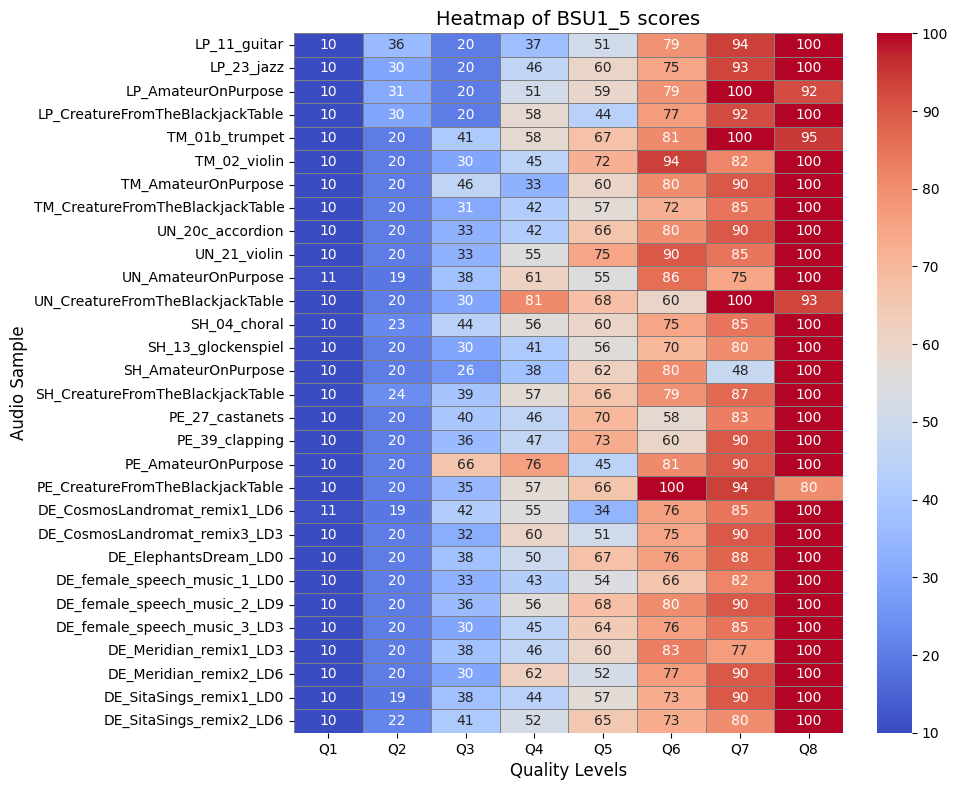

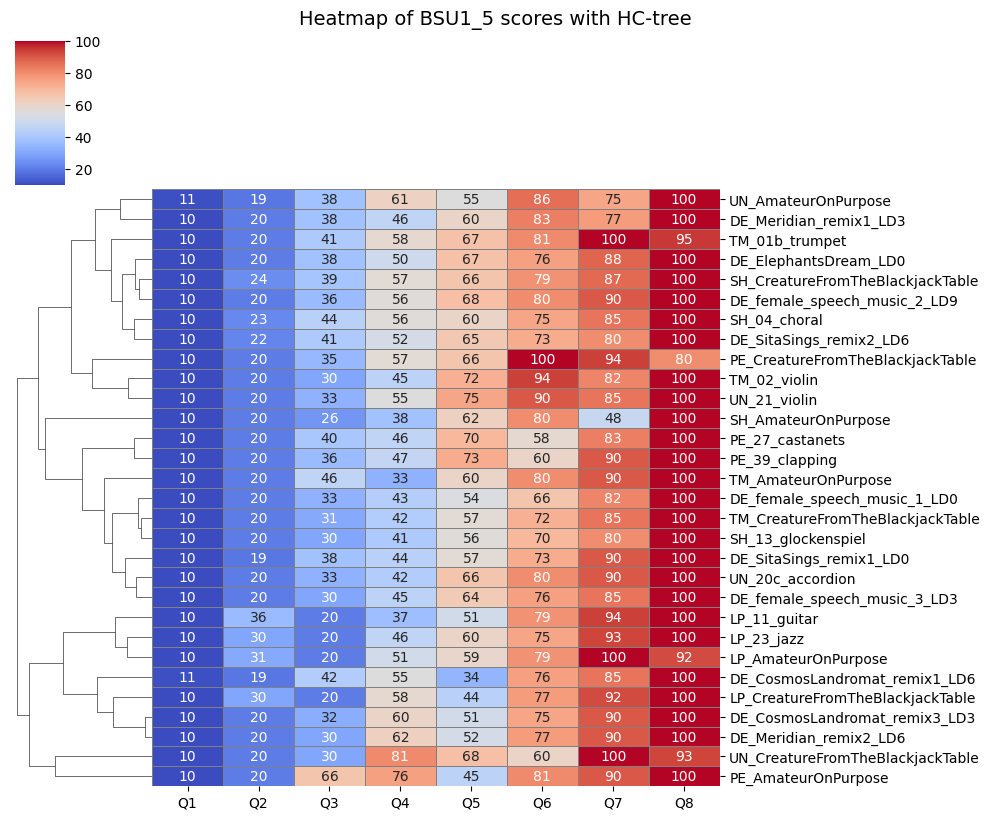

In [182]:
plot_heatmap(np.array(BSU1_5_scores), items=items, listener='BSU1_5', annot=True)
plot_clustermap(np.array(BSU1_5_scores), items=items, listener='BSU1_5', annot=True)

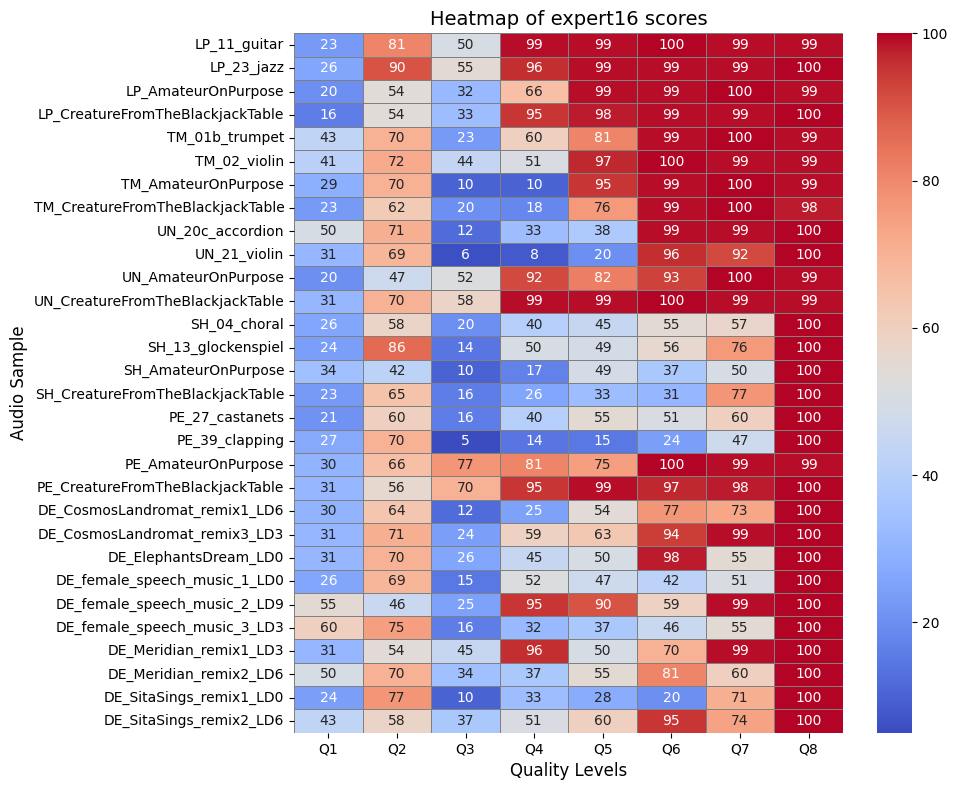

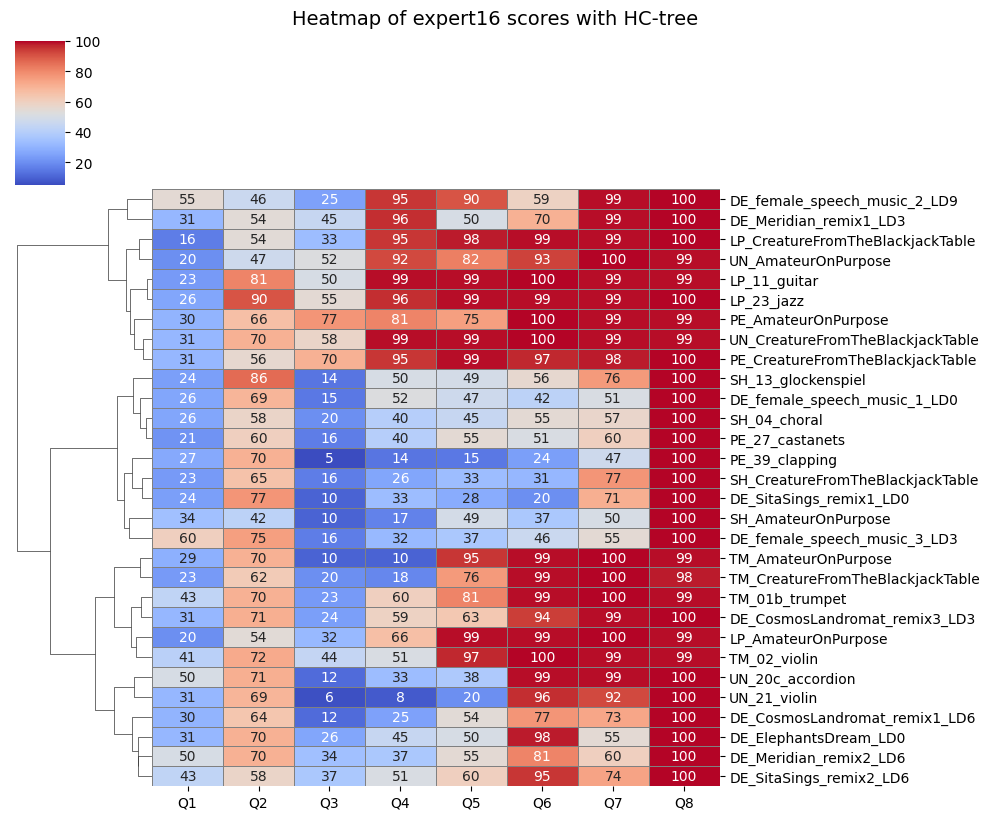

In [183]:
plot_heatmap(np.array(expert16_scores), items=items, listener='expert16', annot=True)
plot_clustermap(np.array(expert16_scores), items=items, listener='expert16', annot=True)

In [184]:
easy_easiest_trials_competition_kmeans = ['TM_01b_trumpet', 'DE_ElephantsDream_LD0', 'LP_23_jazz', 'LP_AmateurOnPurpose', 'DE_female_speech_music_2_LD9', 'UN_AmateurOnPurpose', 'UN_CreatureFromTheBlackjackTable']
hard_hardest_trials_competition_kmeans = ['SH_AmateurOnPurpose', 'SH_CreatureFromTheBlackjackTable', 'DE_SitaSings_remix2_LD6', 'PE_27_castanets']

In [185]:
reversed_perfect_ranking = np.array([8, 7, 6, 5, 4, 3, 2, 1])

# Create DataFrame for perfect ranking
perfect_df = pd.DataFrame({
    'Sample': ['Perfect Ranking'] * len(conditions),
    'Condition': conditions,
    'Ranking': reversed_perfect_ranking
})

In [186]:
# Spaghetti plot for BSU2_1 rankings

reversed_BSU1_5_rankings = BSU1_5_rankings[:, ::-1]

# Reshape rankings data for Plotly
BSU1_5_rankings_df = pd.DataFrame(reversed_BSU1_5_rankings, columns=conditions)

BSU1_5_rankings_df['Sample'] = items

# Melt dataframe for better visualization
BSU1_5_rankings_df_melted = BSU1_5_rankings_df.melt(id_vars=['Sample'], var_name='Condition', value_name='Ranking')

BSU1_5_rankings_df_melted = pd.concat([perfect_df, BSU1_5_rankings_df_melted])

# Define custom colors
color_map = {
    "Perfect Ranking": "black"
}

# Assign green to easy items
for item in easy_easiest_trials_competition_kmeans:
    color_map[item] = "green"

# Assign red to hard items
for item in hard_hardest_trials_competition_kmeans:
    color_map[item] = "red"

# Assign light grey to all other samples
all_samples = BSU1_5_rankings_df_melted['Sample'].unique()
for item in all_samples:
    if item not in color_map:
        color_map[item] = "lightgrey"

# Create the line plot with custom colors
fig = px.line(BSU1_5_rankings_df_melted, x='Condition', y='Ranking', color='Sample', markers=True,
              title="Cohort 1 Student 5 (Competition) Rankings per Condition with Perfect Ranking Reference",
              labels={"Ranking": "Ranking (Lower is Better)", "Condition": "Conditions (Low to High Quality)"},
              color_discrete_map=color_map,
              template="plotly_white")

# Adjust figure dimensions
fig.update_layout(width=1000, height=800)

# Invert y-axis (lower ranks at top)
fig.update_yaxes(autorange="reversed")

# Modify the "Perfect Ranking" line to be more visible
fig.update_traces(
    selector=dict(name="Perfect Ranking"),
    line=dict(width=10, color='black'),
    marker=dict(size=14, color='black')
)


In [187]:
# Spaghetti plot for Expert 16 rankings

reversed_expert16_rankings_hard_hardest = expert16_rankings[:, ::-1]

# Reshape rankings data for Plotly
expert16_rankings_df = pd.DataFrame(reversed_expert16_rankings_hard_hardest, columns=conditions)
expert16_rankings_df['Sample'] = items

# Melt dataframe for better visualization
expert16_rankings_df_melted = expert16_rankings_df.melt(id_vars=['Sample'], var_name='Condition', value_name='Ranking')

expert16_rankings_df_melted = pd.concat([perfect_df, expert16_rankings_df_melted])


# Define custom colors
color_map = {
    "Perfect Ranking": "black"
}

# Assign green to easy items
for item in easy_easiest_trials_competition_kmeans:
    color_map[item] = "green"

# Assign red to hard items
for item in hard_hardest_trials_competition_kmeans:
    color_map[item] = "red"

# Assign light grey to all other samples
all_samples = expert16_rankings_df_melted['Sample'].unique()
for item in all_samples:
    if item not in color_map:
        color_map[item] = "lightgrey"

# Create plot
fig = px.line(expert16_rankings_df_melted, x='Condition', y='Ranking', color='Sample', markers=True,
              title="Expert 16 (Competition) Rankings per Condition with Perfect Ranking Reference",
              labels={"Ranking": "Ranking (Lower is Better)", "Condition": "Conditions (Low to High Quality)"},
              color_discrete_map=color_map,
              template="plotly_white")

# Adjust figure dimensions
fig.update_layout(width=1000, height=800)

# Invert y-axis (lower ranks at top)
fig.update_yaxes(autorange="reversed")

# Modify the "Perfect Ranking" line to be more visible
fig.update_traces(
    selector=dict(name="Perfect Ranking"),
    line=dict(width=10, color='black'),
    marker=dict(size=14, color='black')
)

# Show figure
fig.show()

In [188]:
# import all .wav files from ODAQ/ODAQ_unprocessed/

import os
import glob
import shutil
import soundfile as sf
import librosa
import librosa.display as ld
import numpy as np

# find all .wav files in the directory
directory = './ODAQ/ODAQ_listening_test/TM_01b_trumpet/'
wav_files = glob.glob(os.path.join(directory, '*.wav'))
# print the list of .wav files

for file in wav_files:
    print(file)


./ODAQ/ODAQ_listening_test/TM_01b_trumpet/TM3k.wav
./ODAQ/ODAQ_listening_test/TM_01b_trumpet/reference.wav
./ODAQ/ODAQ_listening_test/TM_01b_trumpet/LP70.wav
./ODAQ/ODAQ_listening_test/TM_01b_trumpet/TM9k.wav
./ODAQ/ODAQ_listening_test/TM_01b_trumpet/TM5k.wav
./ODAQ/ODAQ_listening_test/TM_01b_trumpet/TM7k.wav
./ODAQ/ODAQ_listening_test/TM_01b_trumpet/LP35.wav
./ODAQ/ODAQ_listening_test/TM_01b_trumpet/TM10.5k.wav


In [189]:
easy_easiest_trials_competition_kmeans[0]

'TM_01b_trumpet'

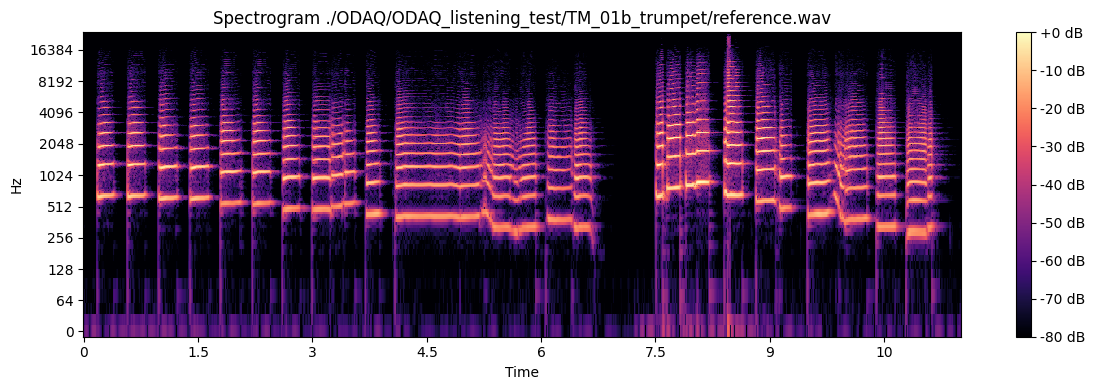

In [190]:
y, sr = librosa.load(wav_files[1], sr=None)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

plt.figure(figsize=(12, 4))
ld.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Spectrogram {wav_files[1]}')
plt.tight_layout()
plt.show()

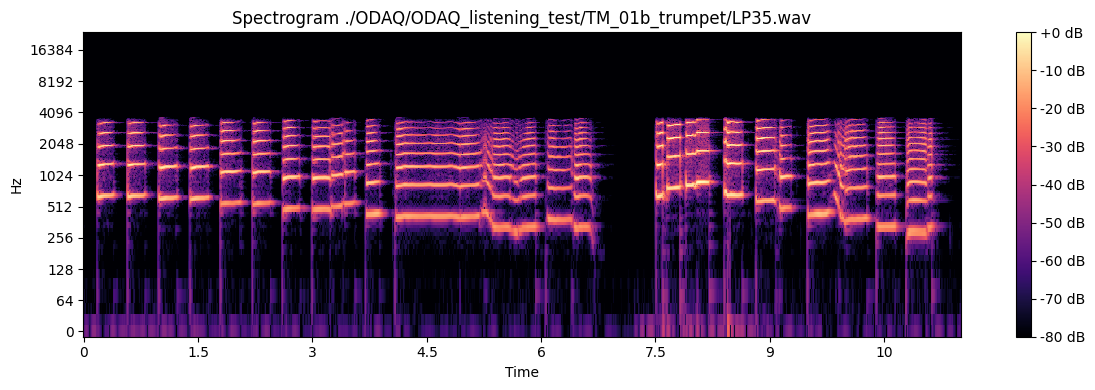

In [191]:
y, sr = librosa.load(wav_files[-2], sr=None)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

plt.figure(figsize=(12, 4))
ld.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Spectrogram {wav_files[-2]}')
plt.tight_layout()
plt.show()

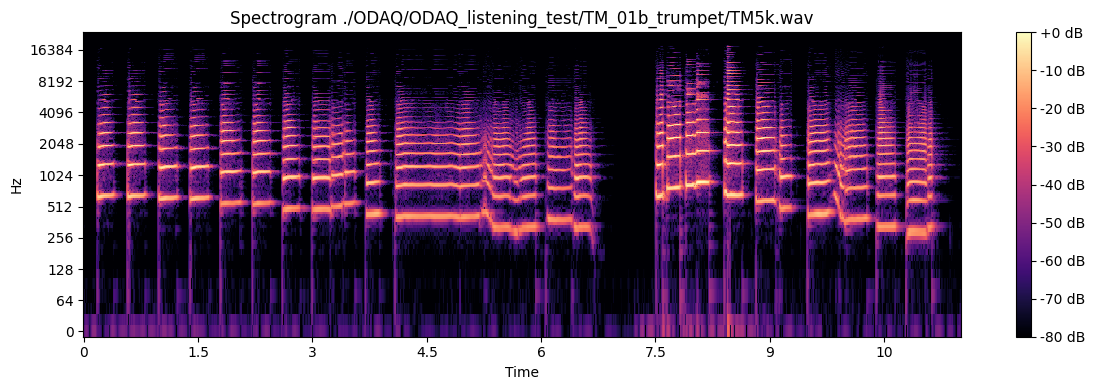

In [192]:
y, sr = librosa.load(wav_files[4], sr=None)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

plt.figure(figsize=(12, 4))
ld.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Spectrogram {wav_files[4]}')
plt.tight_layout()
plt.show()

In [193]:
# import all .wav files from ODAQ/ODAQ_unprocessed/

import os
import glob
import shutil
import soundfile as sf
import librosa
import librosa.display as ld
import numpy as np

# find all .wav files in the directory
directory = './ODAQ/ODAQ_listening_test/SH_AmateurOnPurpose/'
wav_files = glob.glob(os.path.join(directory, '*.wav'))
# print the list of .wav files

for file in wav_files:
    print(file)


./ODAQ/ODAQ_listening_test/SH_AmateurOnPurpose/SH70_MS.wav
./ODAQ/ODAQ_listening_test/SH_AmateurOnPurpose/reference.wav
./ODAQ/ODAQ_listening_test/SH_AmateurOnPurpose/LP70.wav
./ODAQ/ODAQ_listening_test/SH_AmateurOnPurpose/SH50_MS.wav
./ODAQ/ODAQ_listening_test/SH_AmateurOnPurpose/SH10_MS.wav
./ODAQ/ODAQ_listening_test/SH_AmateurOnPurpose/SH30_MS.wav
./ODAQ/ODAQ_listening_test/SH_AmateurOnPurpose/SH20_MS.wav
./ODAQ/ODAQ_listening_test/SH_AmateurOnPurpose/LP35.wav


In [194]:
hard_hardest_trials_competition_kmeans[0]

'SH_AmateurOnPurpose'

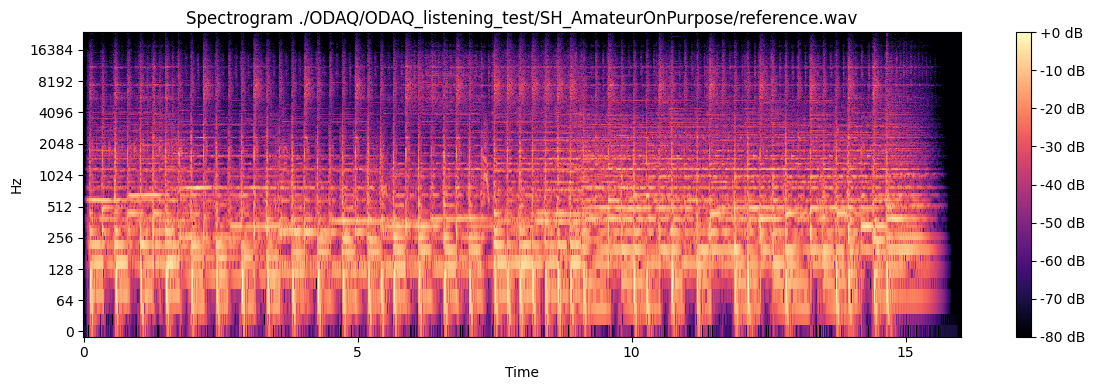

In [195]:
y, sr = librosa.load(wav_files[1], sr=None)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

plt.figure(figsize=(12, 4))
ld.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Spectrogram {wav_files[1]}')
plt.tight_layout()
plt.show()

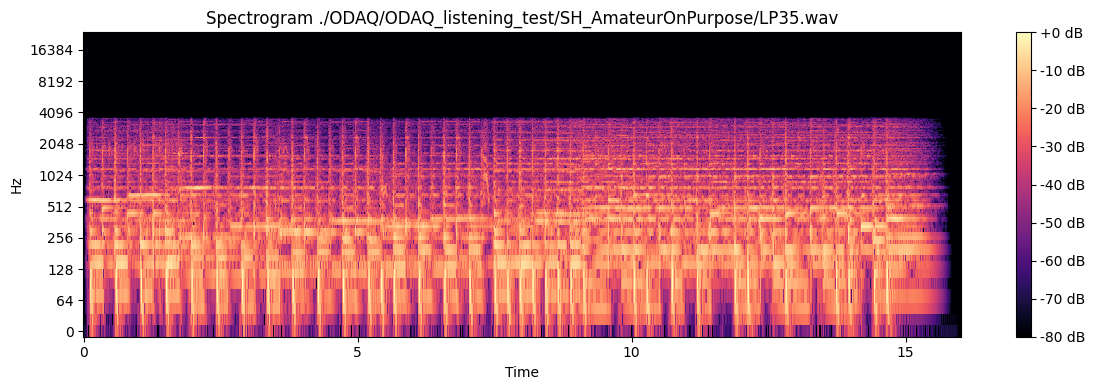

In [196]:
y, sr = librosa.load(wav_files[-1], sr=None)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

plt.figure(figsize=(12, 4))
ld.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Spectrogram {wav_files[-1]}')
plt.tight_layout()
plt.show()

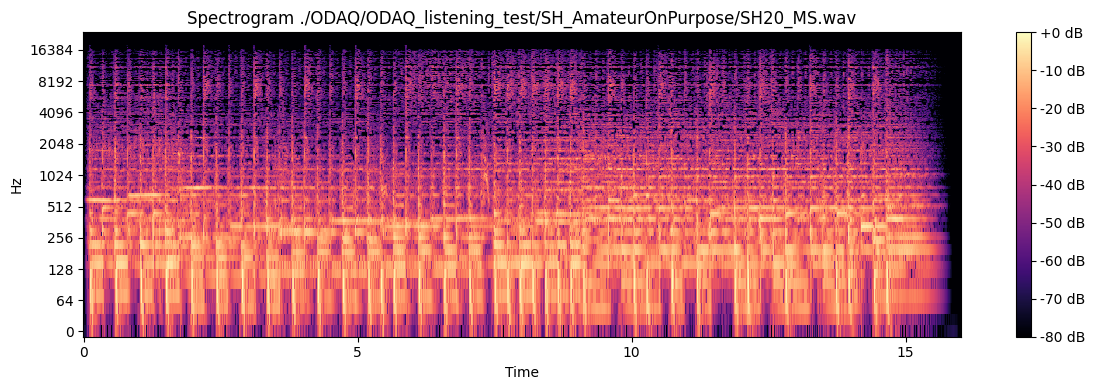

In [197]:
y, sr = librosa.load(wav_files[6], sr=None)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

plt.figure(figsize=(12, 4))
ld.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Spectrogram {wav_files[6]}')
plt.tight_layout()
plt.show()